# Vertex Model Monitoring



## Overview

### What is Model Monitoring?

Modern applications rely on a well established set of capabilities to monitor the health of their services. Examples include:

* software versioning
* rigorous deployment processes
* event logging
* alerting/notication of situations requiring intervention
* on-demand and automated diagnostic tracing
* automated performance and functional testing

You should be able to manage your ML services with the same degree of power and flexibility with which you can manage your applications. That's what MLOps is all about - managing ML services with the best practices Google and the broader computing industry have learned from generations of experience deploying well engineered, reliable, and scalable services.

Model monitoring is only one piece of the ML Ops puzzle - it helps answer the following questions:

* How well do recent service requests match the training data used to build your model? This is called **training-serving skew**.
* How significantly are service requests evolving over time? This is called **drift detection**.

If production traffic differs from  training data, or varies substantially over time, that's likely to impact the quality of the answers your model produces. When that happens, you'd like to be alerted automatically and responsively, so that **you can anticipate problems before they affect your customer experiences or your revenue streams**.

### Learning Objective

In this notebook, you will learn how to... 

* Deploy a pre-trained model
* Configure model monitoring
* Generate some artificial traffic
* Understand how to interpret the statistics, visualizations, other data reported by the model monitoring feature

### Costs 

This tutorial uses billable components of Google Cloud:

* Vertext AI
* BigQuery

Learn about [Vertext AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### The example model

The model you'll use in this notebook is based on [this blog post](https://cloud.google.com/blog/topics/developers-practitioners/churn-prediction-game-developers-using-google-analytics-4-ga4-and-bigquery-ml). The idea behind this model is that your company has extensive log data describing how your game users have interacted with the site. The raw data contains the following categories of information:

- identity - unique player identitity numbers
- demographic features - information about the player, such as the geographic region in which a player is located
- behavioral features - counts of the number of times a  player has triggered certain game events, such as reaching a new level
- churn propensity - this is the label or target feature, it provides an estimated probability that this player will churn, i.e. stop being an active player.

The blog article referenced above explains how to use BigQuery to store the raw data, pre-process it for use in machine learning, and train a model. Because this notebook focuses on model monitoring, rather than training models, you're going to reuse a pre-trained version of this model, which has been exported to Google Cloud Storage. In the next section, you will setup your environment and import this model into your own project.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [Solution Notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/art_and_science_of_ml/solutions/model_monitoring.ipynb) for reference. 


## Before you begin

### Setup your dependencies

In [1]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# Google Cloud Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

In [2]:
import os
import sys

import IPython

assert sys.version_info.major == 3, "This notebook requires Python 3."

# Install Python package dependencies.
print("Installing TensorFlow 2.4.1 and TensorFlow Data Validation (TFDV)")
! pip3 install {USER_FLAG} --quiet --upgrade tensorflow==2.4.1 tensorflow_data_validation[visualization]
! pip3 install {USER_FLAG} --quiet --upgrade google-api-python-client google-auth-oauthlib google-auth-httplib2 oauth2client requests
! pip3 install {USER_FLAG} --quiet --upgrade google-cloud-aiplatform
! pip3 install {USER_FLAG} --quiet --upgrade google-cloud-storage==1.32.0

# Automatically restart kernel after installing new packages.
if not os.getenv("IS_TESTING"):
    print("Restarting kernel...")
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    print("Done.")

Installing TensorFlow 2.4.1 and TensorFlow Data Validation (TFDV)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.18.0 requires tensorflow-io-gcs-filesystem==0.18.0, which is not installed.
tensorflow-transform 1.2.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,<2.6,>=1.15.2, but you have tensorflow 2.4.1 which is incompatible.
tensorflow-transform 1.2.0 requires tensorflow-metadata<1.3.0,>=1.2.0, but you have tensorflow-metadata 0.30.0 which is incompatible.
tensorflow-transform 1.2.0 requires tfx-bsl<1.3.0,>=1.2.0, but you have tfx-bsl 0.30.0 which is incompatible.
tensorflow-io 0.18.0 requires tensorf

In [1]:
import os
import random
import sys
import time

# Import required packages.
import numpy as np

### Set up your Google Cloud project

**For this lab, we're going to use region us-central1 for all our resources (BigQuery training data, Cloud Storage bucket, model and endpoint locations, etc.). Those resources can be deployed in other regions, as long as they're consistently co-located, but we're going to use one fixed region to keep things as simple and error free as possible.**

In [2]:
PROJECT_ID = "[your-project-id]"
REGION = "us-central1"
SUFFIX = "aiplatform.googleapis.com"
API_ENDPOINT = f"{REGION}-{SUFFIX}"
PREDICT_API_ENDPOINT = f"{REGION}-prediction-{SUFFIX}"
if os.getenv("IS_TESTING"):
    !gcloud --quiet components install beta
    !gcloud --quiet components update
!gcloud config set project $PROJECT_ID
!gcloud config set ai/region $REGION

Updated property [core/project].
Updated property [ai/region].


### Login to your Google Cloud account and enable AI services

In [3]:
# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# If on Google Cloud Notebooks, then don't execute this code
if not IS_GOOGLE_CLOUD_NOTEBOOK:
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

!gcloud services enable aiplatform.googleapis.com

Operation "operations/acf.p2-346810986095-756e3ab7-4ed8-430a-b9b7-7a7a26e4023b" finished successfully.


### Define some helper functions

Run the following cell to define some utility functions used throughout this notebook. Although these functions are not critical to understand the main concepts, feel free to expand the  cell if you're curious or want to dive deeper into how some of your API requests are made.

In [4]:
# @title Utility functions
import copy
import os

from google.cloud.aiplatform_v1beta1.services.endpoint_service import \
    EndpointServiceClient
from google.cloud.aiplatform_v1beta1.services.job_service import \
    JobServiceClient
from google.cloud.aiplatform_v1beta1.services.prediction_service import \
    PredictionServiceClient
from google.cloud.aiplatform_v1beta1.types.io import BigQuerySource
from google.cloud.aiplatform_v1beta1.types.model_deployment_monitoring_job import (
    ModelDeploymentMonitoringJob, ModelDeploymentMonitoringObjectiveConfig,
    ModelDeploymentMonitoringScheduleConfig)
from google.cloud.aiplatform_v1beta1.types.model_monitoring import (
    ModelMonitoringAlertConfig, ModelMonitoringObjectiveConfig,
    SamplingStrategy, ThresholdConfig)
from google.cloud.aiplatform_v1beta1.types.prediction_service import \
    PredictRequest
from google.protobuf import json_format
from google.protobuf.duration_pb2 import Duration
from google.protobuf.struct_pb2 import Value

DEFAULT_THRESHOLD_VALUE = 0.001


def create_monitoring_job(objective_configs):
    # Create sampling configuration.
    random_sampling = SamplingStrategy.RandomSampleConfig(sample_rate=LOG_SAMPLE_RATE)
    sampling_config = SamplingStrategy(random_sample_config=random_sampling)

    # Create schedule configuration.
    duration = Duration(seconds=MONITOR_INTERVAL)
    schedule_config = ModelDeploymentMonitoringScheduleConfig(monitor_interval=duration)

    # Create alerting configuration.
    emails = [USER_EMAIL]
    email_config = ModelMonitoringAlertConfig.EmailAlertConfig(user_emails=emails)
    alerting_config = ModelMonitoringAlertConfig(email_alert_config=email_config)

    # Create the monitoring job.
    endpoint = f"projects/{PROJECT_ID}/locations/{REGION}/endpoints/{ENDPOINT_ID}"
    predict_schema = ""
    analysis_schema = ""
    job = ModelDeploymentMonitoringJob(
        display_name=JOB_NAME,
        endpoint=endpoint,
        model_deployment_monitoring_objective_configs=objective_configs,
        logging_sampling_strategy=sampling_config,
        model_deployment_monitoring_schedule_config=schedule_config,
        model_monitoring_alert_config=alerting_config,
        predict_instance_schema_uri=predict_schema,
        analysis_instance_schema_uri=analysis_schema,
    )
    options = dict(api_endpoint=API_ENDPOINT)
    client = JobServiceClient(client_options=options)
    parent = f"projects/{PROJECT_ID}/locations/{REGION}"
    response = client.create_model_deployment_monitoring_job(
        parent=parent, model_deployment_monitoring_job=job
    )
    print("Created monitoring job:")
    print(response)
    return response


def get_thresholds(default_thresholds, custom_thresholds):
    thresholds = {}
    default_threshold = ThresholdConfig(value=DEFAULT_THRESHOLD_VALUE)
    for feature in default_thresholds.split(","):
        feature = feature.strip()
        thresholds[feature] = default_threshold
    for custom_threshold in custom_thresholds.split(","):
        pair = custom_threshold.split(":")
        if len(pair) != 2:
            print(f"Invalid custom skew threshold: {custom_threshold}")
            return
        feature, value = pair
        thresholds[feature] = ThresholdConfig(value=float(value))
    return thresholds


def get_deployed_model_ids(endpoint_id):
    client_options = dict(api_endpoint=API_ENDPOINT)
    client = EndpointServiceClient(client_options=client_options)
    parent = f"projects/{PROJECT_ID}/locations/{REGION}"
    response = client.get_endpoint(name=f"{parent}/endpoints/{endpoint_id}")
    model_ids = []
    for model in response.deployed_models:
        model_ids.append(model.id)
    return model_ids


def set_objectives(model_ids, objective_template):
    # Use the same objective config for all models.
    objective_configs = []
    for model_id in model_ids:
        objective_config = copy.deepcopy(objective_template)
        objective_config.deployed_model_id = model_id
        objective_configs.append(objective_config)
    return objective_configs


def send_predict_request(endpoint, input):
    client_options = {"api_endpoint": PREDICT_API_ENDPOINT}
    client = PredictionServiceClient(client_options=client_options)
    params = {}
    params = json_format.ParseDict(params, Value())
    request = PredictRequest(endpoint=endpoint, parameters=params)
    inputs = [json_format.ParseDict(input, Value())]
    request.instances.extend(inputs)
    response = client.predict(request)
    return response


def list_monitoring_jobs():
    client_options = dict(api_endpoint=API_ENDPOINT)
    parent = f"projects/{PROJECT_ID}/locations/us-central1"
    client = JobServiceClient(client_options=client_options)
    response = client.list_model_deployment_monitoring_jobs(parent=parent)
    print(response)


def pause_monitoring_job(job):
    client_options = dict(api_endpoint=API_ENDPOINT)
    client = JobServiceClient(client_options=client_options)
    response = client.pause_model_deployment_monitoring_job(name=job)
    print(response)


def delete_monitoring_job(job):
    client_options = dict(api_endpoint=API_ENDPOINT)
    client = JobServiceClient(client_options=client_options)
    response = client.delete_model_deployment_monitoring_job(name=job)
    print(response)


# Sampling distributions for categorical features...
DAYOFWEEK = {1: 1040, 2: 1223, 3: 1352, 4: 1217, 5: 1078, 6: 1011, 7: 1110}
LANGUAGE = {
    "en-us": 4807,
    "en-gb": 678,
    "ja-jp": 419,
    "en-au": 310,
    "en-ca": 299,
    "de-de": 147,
    "en-in": 130,
    "en": 127,
    "fr-fr": 94,
    "pt-br": 81,
    "es-us": 65,
    "zh-tw": 64,
    "zh-hans-cn": 55,
    "es-mx": 53,
    "nl-nl": 37,
    "fr-ca": 34,
    "en-za": 29,
    "vi-vn": 29,
    "en-nz": 29,
    "es-es": 25,
}
OS = {"IOS": 3980, "ANDROID": 3798, "null": 253}
MONTH = {6: 3125, 7: 1838, 8: 1276, 9: 1718, 10: 74}
COUNTRY = {
    "United States": 4395,
    "India": 486,
    "Japan": 450,
    "Canada": 354,
    "Australia": 327,
    "United Kingdom": 303,
    "Germany": 144,
    "Mexico": 102,
    "France": 97,
    "Brazil": 93,
    "Taiwan": 72,
    "China": 65,
    "Saudi Arabia": 49,
    "Pakistan": 48,
    "Egypt": 46,
    "Netherlands": 45,
    "Vietnam": 42,
    "Philippines": 39,
    "South Africa": 38,
}

# Means and standard deviations for numerical features...
MEAN_SD = {
    "julianday": (204.6, 34.7),
    "cnt_user_engagement": (30.8, 53.2),
    "cnt_level_start_quickplay": (7.8, 28.9),
    "cnt_level_end_quickplay": (5.0, 16.4),
    "cnt_level_complete_quickplay": (2.1, 9.9),
    "cnt_level_reset_quickplay": (2.0, 19.6),
    "cnt_post_score": (4.9, 13.8),
    "cnt_spend_virtual_currency": (0.4, 1.8),
    "cnt_ad_reward": (0.1, 0.6),
    "cnt_challenge_a_friend": (0.0, 0.3),
    "cnt_completed_5_levels": (0.1, 0.4),
    "cnt_use_extra_steps": (0.4, 1.7),
}

DEFAULT_INPUT = {
    "cnt_ad_reward": 0,
    "cnt_challenge_a_friend": 0,
    "cnt_completed_5_levels": 1,
    "cnt_level_complete_quickplay": 3,
    "cnt_level_end_quickplay": 5,
    "cnt_level_reset_quickplay": 2,
    "cnt_level_start_quickplay": 6,
    "cnt_post_score": 34,
    "cnt_spend_virtual_currency": 0,
    "cnt_use_extra_steps": 0,
    "cnt_user_engagement": 120,
    "country": "Denmark",
    "dayofweek": 3,
    "julianday": 254,
    "language": "da-dk",
    "month": 9,
    "operating_system": "IOS",
    "user_pseudo_id": "104B0770BAE16E8B53DF330C95881893",
}

## Import your model

The churn propensity model you'll be using in this notebook has been trained in BigQuery ML and exported to a Google Cloud Storage bucket. This illustrates how you can easily export a trained model and move a model from one cloud service to another. 

Run the next cell to import this model into your project. **If you've already imported your model, you can skip this step.**

In [5]:
# TODO
MODEL_NAME = "churn"
IMAGE = "us-docker.pkg.dev/cloud-aiplatform/prediction/tf2-cpu.2-4:latest"
ARTIFACT = "gs://mco-mm/churn"
output = !gcloud --quiet beta ai models upload --container-image-uri=$IMAGE --artifact-uri=$ARTIFACT --display-name=$MODEL_NAME --format="value(model)"
print("model output: ", output)
MODEL_ID = # TODO: Your code goes here
print(f"Model {MODEL_NAME}/{MODEL_ID} created.")

model output:  ['Using endpoint [https://us-central1-aiplatform.googleapis.com/]', 'projects/346810986095/locations/us-central1/models/4351946187574607872', 'Waiting for operation [4975491601192189952]...', '................................................................................................done.']
Model churn/4351946187574607872 created.


## Deploy your endpoint

Now that you've imported your model into your project, you need to create an endpoint to serve your model. An endpoint can be thought of as a channel through which your model provides prediction services. Once established, you'll be able to make prediction requests on your model via the public internet.  Your endpoint is also serverless, in the sense that Google ensures high availability by reducing single points of failure, and scalability by dynamically allocating resources to meet the demand for your service. In this way, you are able to focus on your model quality, and freed from adminstrative and infrastructure concerns.

Run the next cell to deploy your model to an endpoint. **This will take about ten minutes to complete. If you've already deployed a model to an endpoint, you can reuse your endpoint by running the cell after the next one.**

In [6]:
# TODO
ENDPOINT_NAME = "churn"
output = !gcloud --quiet beta ai endpoints create --display-name=$ENDPOINT_NAME --format="value(name)"
print("endpoint output: ", output)
ENDPOINT = output[-1]
ENDPOINT_ID = # TODO: Your code goes here
output = !gcloud --quiet beta ai endpoints deploy-model $ENDPOINT_ID --display-name=$ENDPOINT_NAME --model=$MODEL_ID --traffic-split="0=100"
DEPLOYED_MODEL_ID = # TODO: Your code goes here
print(
    f"Model {MODEL_NAME}/{MODEL_ID}/{DEPLOYED_MODEL_ID} deployed to Endpoint {ENDPOINT_NAME}/{ENDPOINT_ID}/{ENDPOINT}."
)

endpoint output:  ['Using endpoint [https://us-central1-aiplatform.googleapis.com/]', 'Waiting for operation [5397704066258173952]...', '........................................done.', 'Created Vertex AI endpoint: projects/346810986095/locations/us-central1/endpoints/3623550520498585600.', 'projects/346810986095/locations/us-central1/endpoints/3623550520498585600']
Model churn/4351946187574607872/[4171599067706556416].. deployed to Endpoint churn/3623550520498585600/projects/346810986095/locations/us-central1/endpoints/3623550520498585600.


## Run a prediction test

Now that you have imported a model and deployed that model to an endpoint, you are ready to verify that it's working. Run the next cell to send a test prediction request. If everything works as expected, you should receive a response encoded in a text representation called JSON.

**Try this now by running the next cell and examine the results.**

In [7]:
import pprint as pp

print(ENDPOINT)
print("request:")
pp.pprint(DEFAULT_INPUT)
try:
    resp = send_predict_request(ENDPOINT, DEFAULT_INPUT)
    print("response")
    pp.pprint(resp)
except Exception:
    print("prediction request failed")

projects/346810986095/locations/us-central1/endpoints/3623550520498585600
request:
{'cnt_ad_reward': 0,
 'cnt_challenge_a_friend': 0,
 'cnt_completed_5_levels': 1,
 'cnt_level_complete_quickplay': 3,
 'cnt_level_end_quickplay': 5,
 'cnt_level_reset_quickplay': 2,
 'cnt_level_start_quickplay': 6,
 'cnt_post_score': 34,
 'cnt_spend_virtual_currency': 0,
 'cnt_use_extra_steps': 0,
 'cnt_user_engagement': 120,
 'country': 'Denmark',
 'dayofweek': 3,
 'julianday': 254,
 'language': 'da-dk',
 'month': 9,
 'operating_system': 'IOS',
 'user_pseudo_id': '104B0770BAE16E8B53DF330C95881893'}
response
predictions {
  struct_value {
    fields {
      key: "churned_probs"
      value {
        list_value {
          values {
            number_value: 0.8705776921658448
          }
          values {
            number_value: 0.1294223078341552
          }
        }
      }
    }
    fields {
      key: "churned_values"
      value {
        list_value {
          values {
            string_value: "

Taking a closer look at the results, we see the following elements:

- **churned_values** - a set of possible values (0 and 1) for the target field
- **churned_probs** - a corresponding set of probabilities for each possible target field value (5x10^-40 and 1.0, respectively)
- **predicted_churn** - based on the probabilities, the predicted value of the target field (1)

This response encodes the model's prediction in a format that is readily digestible by software, which makes this service ideal for automated use by an application.

## Start your monitoring job

Now that you've created an endpoint to serve prediction requests on your model, you're ready to start a monitoring job to keep an eye on model quality and to alert you if and when input begins to deviate in way that may impact your model's prediction quality.

In this section, you will configure and create a model monitoring job based on the churn propensity model you imported from BigQuery ML.

### Configure the following fields:

1. Log sample rate - Your prediction requests and responses are logged to BigQuery tables, which are automatically created when you create a monitoring job. This parameter specifies the desired logging frequency for those tables.
1. Monitor interval - the  time window over which to analyze your data and report anomalies. The minimum window is one hour (3600 seconds).
1. Target field - the prediction target column name in training dataset.
1. Skew detection threshold - the skew threshold for each feature you want to monitor.
1. Prediction drift threshold - the drift threshold for each feature you want to monitor.

In [8]:
USER_EMAIL = "[your-mail-id]"
JOB_NAME = "churn"

# Sampling rate (optional, default=.8)
LOG_SAMPLE_RATE = 0.8 

# Monitoring Interval in seconds (optional, default=3600).
MONITOR_INTERVAL = 3600  

# URI to training dataset.
DATASET_BQ_URI = "bq://mco-mm.bqmlga4.train" 
# Prediction target column name in training dataset.
TARGET = "churned"

# Skew and drift thresholds.
SKEW_DEFAULT_THRESHOLDS = "country,language" 
SKEW_CUSTOM_THRESHOLDS = "cnt_user_engagement:.5" 
DRIFT_DEFAULT_THRESHOLDS = "country,language" 
DRIFT_CUSTOM_THRESHOLDS = "cnt_user_engagement:.5" 

### Create your monitoring job

The following code uses the Google Python client library to translate your configuration settings into a programmatic request to start a model monitoring job. Instantiating a monitoring job can take some time. If everything looks good with your request, you'll get a successful API response. Then, you'll need to check your email to receive a notification that the job is running.

In [9]:
# TODO
skew_thresholds = get_thresholds(SKEW_DEFAULT_THRESHOLDS, SKEW_CUSTOM_THRESHOLDS)
drift_thresholds = get_thresholds(DRIFT_DEFAULT_THRESHOLDS, DRIFT_CUSTOM_THRESHOLDS)
skew_config = ModelMonitoringObjectiveConfig.TrainingPredictionSkewDetectionConfig(
    skew_thresholds=skew_thresholds
)
drift_config = ModelMonitoringObjectiveConfig.PredictionDriftDetectionConfig(
    drift_thresholds=drift_thresholds
)
training_dataset = ModelMonitoringObjectiveConfig.TrainingDataset(target_field=TARGET)
training_dataset.bigquery_source = BigQuerySource(input_uri=DATASET_BQ_URI)
objective_config = ModelMonitoringObjectiveConfig(
    training_dataset=training_dataset,
    training_prediction_skew_detection_config=skew_config,
    prediction_drift_detection_config=drift_config,
)
model_ids = get_deployed_model_ids(ENDPOINT_ID)
objective_template = ModelDeploymentMonitoringObjectiveConfig(
    objective_config=objective_config
)
objective_configs = set_objectives(model_ids, objective_template)

monitoring_job = # TODO: Your code goes here

Created monitoring job:
name: "projects/346810986095/locations/us-central1/modelDeploymentMonitoringJobs/7559047882960011264"
display_name: "churn"
endpoint: "projects/346810986095/locations/us-central1/endpoints/3623550520498585600"
state: JOB_STATE_PENDING
schedule_state: OFFLINE
model_deployment_monitoring_objective_configs {
  deployed_model_id: "2157655230068555776"
  objective_config {
    training_dataset {
      bigquery_source {
        input_uri: "bq://mco-mm.bqmlga4.train"
      }
      target_field: "churned"
    }
    training_prediction_skew_detection_config {
      skew_thresholds {
        key: "cnt_user_engagement"
        value {
          value: 0.5
        }
      }
      skew_thresholds {
        key: "country"
        value {
          value: 0.001
        }
      }
      skew_thresholds {
        key: "language"
        value {
          value: 0.001
        }
      }
    }
    prediction_drift_detection_config {
      drift_thresholds {
        key: "cnt_user_en

In [10]:
# Run a prediction request to generate schema, if necessary.
try:
    _ = send_predict_request(ENDPOINT, DEFAULT_INPUT)
    print("prediction succeeded")
except Exception:
    print("prediction failed")

prediction succeeded


After a minute or two, you should receive email at the address you configured above for USER_EMAIL. This email confirms successful deployment of your monitoring job. Here's a sample of what this email might look like:


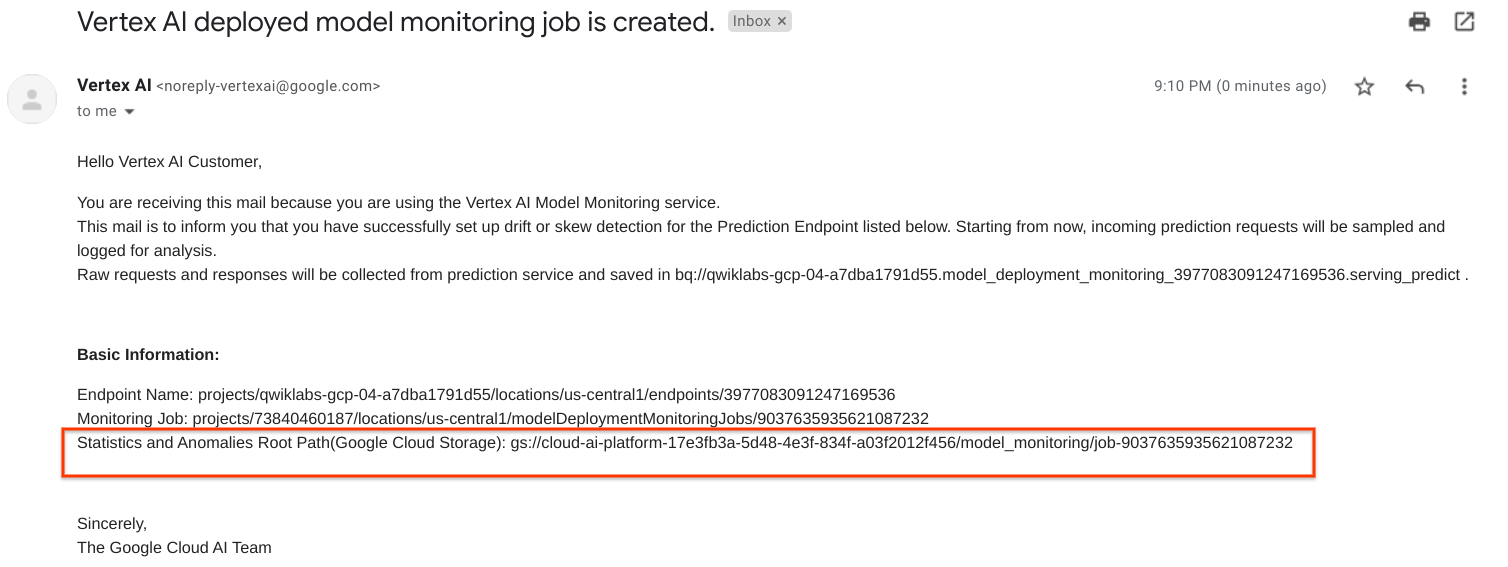

As your monitoring job collects data, measurements are stored in Google Cloud Storage and you are free to examine your data at any time. The circled path in the image above specifies the location of your measurements in Google Cloud Storage. Run the following cell to take a look at your measurements in Cloud Storage.


In [11]:
!gsutil ls gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/*/*

gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/instance_schemas/job-7195547139794010112/:
gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/instance_schemas/job-7195547139794010112/analysis
gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/instance_schemas/job-7195547139794010112/predict

gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/instance_schemas/job-8062415301272141824/:
gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/instance_schemas/job-8062415301272141824/analysis
gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/instance_schemas/job-8062415301272141824/predict

gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/model_monitoring/job-7195547139794010112/:
gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/model_monitoring/job-7195547139794010112/serving/
gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/model_monitoring/job-7195547139794010112/training/

gs://cloud-ai-platform-fdfb48

You will notice the following components in these Cloud Storage paths:

- **cloud-ai-platform-..** - This is a bucket created for you and assigned to capture your service's prediction data. Each monitoring job you create will trigger creation of a new folder in this bucket.
- **[model_monitoring|instance_schemas]/job-..** - This is your unique monitoring job number, which you can see above in both the response to your job creation requesst and the email notification. 
- **instance_schemas/job-../analysis** - This is the monitoring jobs understanding and encoding of your training data's schema (field names, types, etc.).
- **instance_schemas/job-../predict** - This is the first prediction made to your model after the current monitoring job was enabled.
- **model_monitoring/job-../serving** - This folder is used to record data relevant to drift calculations. It contains measurement summaries for every hour your model serves traffic.
- **model_monitoring/job-../training** - This folder is used to record data relevant to training-serving skew calculations. It contains an ongoing summary of prediction data relative to training data.

### You can create monitoring jobs with other user interfaces

In the previous cells, you created a monitoring job using the Python client library. You can also use the *gcloud* command line tool to create a model monitoring job and, in the near future, you will be able to use the Cloud Console, as well for this function. 


## Generate test data to trigger alerting

Now you are ready to test the monitoring function. Run the following cell, which will generate fabricated test predictions designed to trigger the thresholds you specified above. It takes about five minutes to run this cell and at least an hour to assess and report anamolies in skew or drift so after running this cell, feel free to proceed with the notebook and you'll see how to examine the resulting alert later.

In [12]:
def random_uid():
    digits = [str(i) for i in range(10)] + ["A", "B", "C", "D", "E", "F"]
    return "".join(random.choices(digits, k=32))


def monitoring_test(count, sleep, perturb_num={}, perturb_cat={}):
    # Use random sampling and mean/sd with gaussian distribution to model
    # training data. Then modify sampling distros for two categorical features
    # and mean/sd for two numerical features.
    mean_sd = MEAN_SD.copy()
    country = COUNTRY.copy()
    for k, (mean_fn, sd_fn) in perturb_num.items():
        orig_mean, orig_sd = MEAN_SD[k]
        mean_sd[k] = (mean_fn(orig_mean), sd_fn(orig_sd))
    for k, v in perturb_cat.items():
        country[k] = v
    for i in range(0, count):
        input = DEFAULT_INPUT.copy()
        input["user_pseudo_id"] = str(random_uid())
        input["country"] = random.choices([*country], list(country.values()))[0]
        input["dayofweek"] = random.choices([*DAYOFWEEK], list(DAYOFWEEK.values()))[0]
        input["language"] = str(random.choices([*LANGUAGE], list(LANGUAGE.values()))[0])
        input["operating_system"] = str(random.choices([*OS], list(OS.values()))[0])
        input["month"] = random.choices([*MONTH], list(MONTH.values()))[0]
        for key, (mean, sd) in mean_sd.items():
            sample_val = round(float(np.random.normal(mean, sd, 1)))
            val = max(sample_val, 0)
            input[key] = val
        print(f"Sending prediction {i}")
        try:
            send_predict_request(ENDPOINT, input)
        except Exception:
            print("prediction request failed")
        time.sleep(sleep)
    print("Test Completed.")


test_time = 300
tests_per_sec = 1
sleep_time = 1 / tests_per_sec
iterations = # TODO: Your code goes here
perturb_num = {"cnt_user_engagement": (lambda x: x * 3, lambda x: x / 3)}
perturb_cat = {"Japan": max(COUNTRY.values()) * 2}
monitoring_test(iterations, sleep_time, perturb_num, perturb_cat)

Sending prediction 0
Sending prediction 1
Sending prediction 2
Sending prediction 3
Sending prediction 4
Sending prediction 5
Sending prediction 6
Sending prediction 7
Sending prediction 8
Sending prediction 9
Sending prediction 10
Sending prediction 11
Sending prediction 12
Sending prediction 13
Sending prediction 14
Sending prediction 15
Sending prediction 16
Sending prediction 17
Sending prediction 18
Sending prediction 19
Sending prediction 20
Sending prediction 21
Sending prediction 22
Sending prediction 23
Sending prediction 24
Sending prediction 25
Sending prediction 26
Sending prediction 27
Sending prediction 28
Sending prediction 29
Sending prediction 30
Sending prediction 31
Sending prediction 32
Sending prediction 33
Sending prediction 34
Sending prediction 35
Sending prediction 36
Sending prediction 37
Sending prediction 38
Sending prediction 39
Sending prediction 40
Sending prediction 41
Sending prediction 42
Sending prediction 43
Sending prediction 44
Sending prediction 4

## Interpret your results

While waiting for your results, which, as noted, may take up to an hour, you can read ahead to get sense of the alerting experience.

### Here's what a sample email alert looks like...



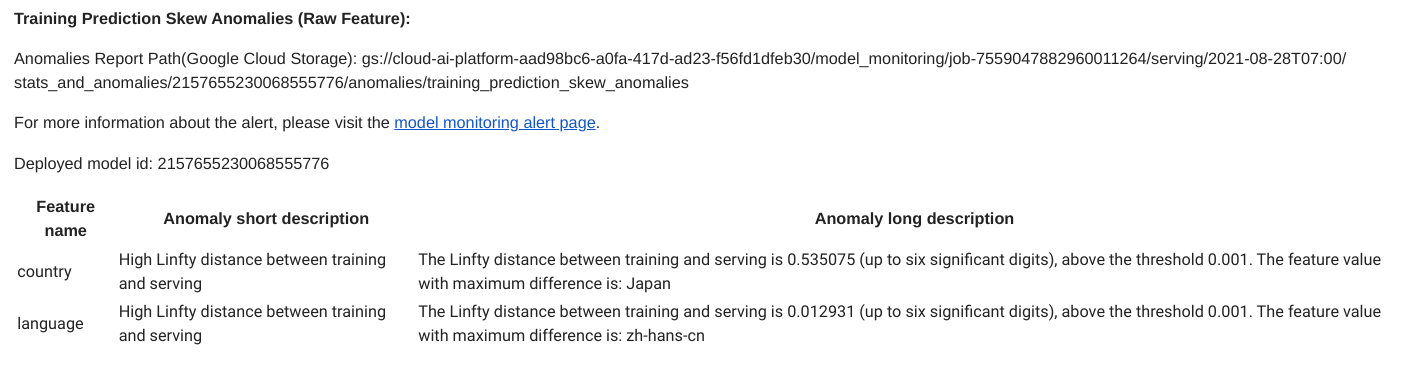

This email is warning you that the *cnt_user_engagement*, *country* and *language* feature values seen in production have skewed above your threshold between training and serving your model. It's also telling you that the *cnt_user_engagement* feature value is drifting significantly over time, again, as per your threshold specification.

### Monitoring results in the Cloud Console

You can examine your model monitoring data from the Cloud Console. Below is a screenshot of those capabilities.

#### Monitoring Status



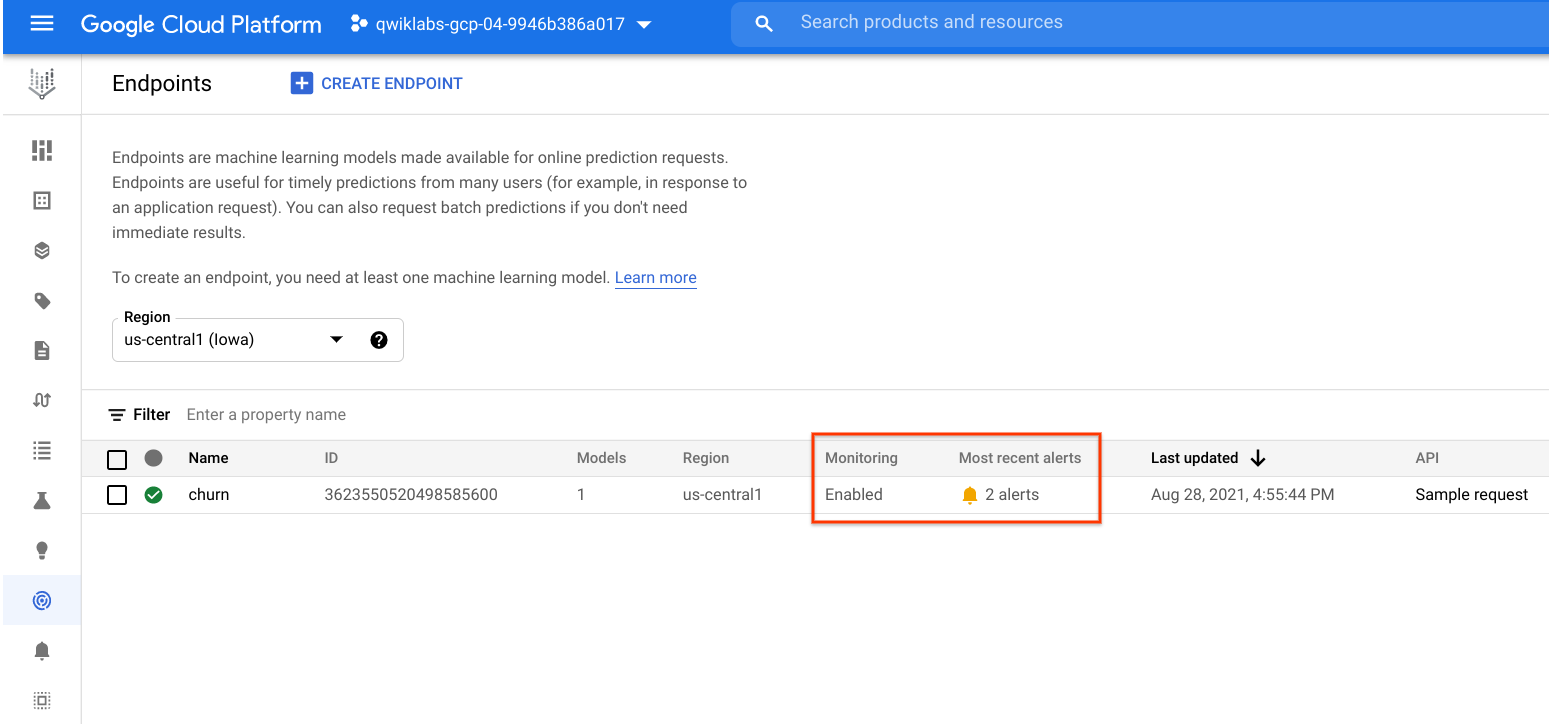

#### Monitoring Alerts



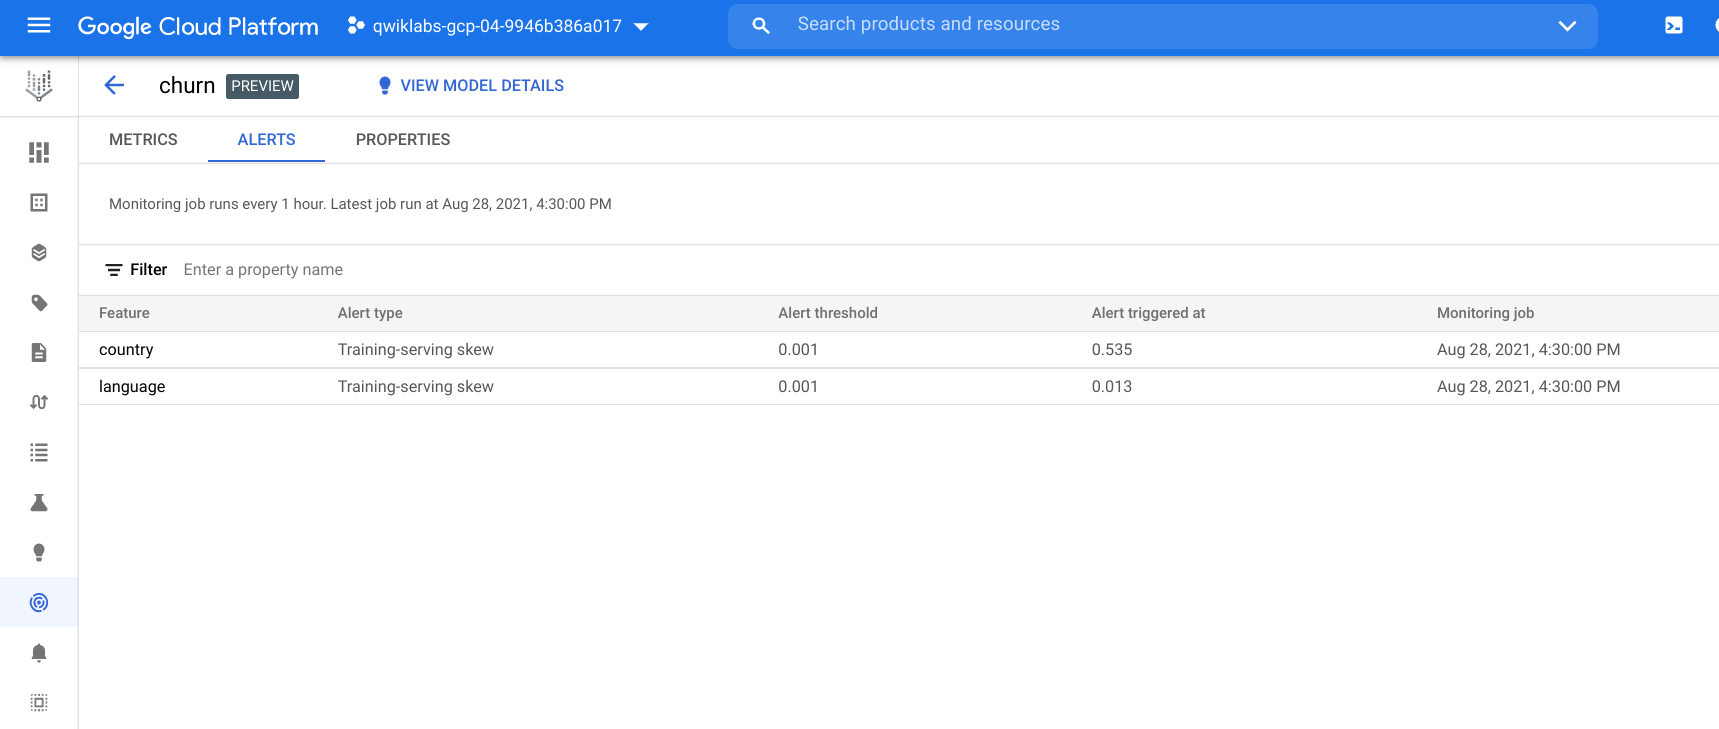

## Learn more about model monitoring

**Congratulations!** You've now learned what model monitoring is, how to configure and enable it, and how to find and interpret the results. Check out the following resources to learn more about model monitoring and ML Ops.

- [TensorFlow Data Validation](https://www.tensorflow.org/tfx/guide/tfdv)
- [Data Understanding, Validation, and Monitoring At Scale](https://blog.tensorflow.org/2018/09/introducing-tensorflow-data-validation.html)
- [Vertex Product Documentation](https://cloud.google.com/vertex)
- [Model Monitoring Reference Docs](https://cloud.google.com/vertex/docs/reference)
- [Model Monitoring blog article](https://cloud.google.com/blog/topics/developers-practitioners/monitor-models-training-serving-skew-vertex-ai)